# 使用全连接神经网络进行中文文本分类

这是一个使用全连接神经网络进行中文文本分类的简易教程，是用的深度学习框架是pytorch，数据是豆瓣读书评论数据:https://www.kaggle.com/datasets/tsaing/douban-book-review

## 安装pytorch
由于本例子中不会使用高级的pytorch库函数，因此使用简单的`pip install torch`进行安装。

如果你的项目对pytorch版本有要求，或者你的设备对一些版本不支持，请参考官方安装指南：
https://pytorch.org/get-started/locally/

在jupyter notebook中，可以将cell设置为代码模式，一般情况下只有python代码可以运行，但如果在最开头加上英文感叹号`!`则可以运行命令行指令，因此这里可以直接在jupyter notebook中安装pytorch。安装的虚拟环境就是你当钱jupyter notebook所使用的虚拟环境，可以在notebook右上方选择或切换虚拟环境。

注：因为这个笔记本的运行环境还没有下载任何包，因此下面也顺便安装其他需要使用的包。

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install scipy
# !pip install sklearn
# !pip install torch

In [2]:
# 调包
import numpy as np
import pandas as pd
import torch
import torch.nn as nn # 这一行不是必要的，有了上一行，之后可以通过`torch.nn`来调用，但是为了简短，再给他一个小名`nn`

In [3]:
# 检查一下是否可以正常使用
print(np.__version__)
print(pd.__version__)
print(torch.__version__)

1.23.4
1.4.4
1.10.2


## 数据准备

1. 导入数据为`pandas.DataFrame`
2. 观察数据的基本情况
3. 按照数据格式，继承`torch.utils.data.Dataset`类，写出自己的数据集类
4. 直接使用`torch.utils.data.DataLoader`类，实例化一个自己的数据载入类

### 导入数据

In [4]:
data_dir = './data/'

In [5]:
# 这个文件有一些读取问题，这里采用下面链接中提到的解决方法：
# https://stackoverflow.com/questions/18016037/pandas-parsererror-eof-character-when-reading-multiple-csv-files-to-hdf5
import csv

In [6]:
train_df = pd.read_csv(f'{data_dir}/train.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)
dev_df = pd.read_csv(f'{data_dir}/dev.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(f'{data_dir}/test.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

### 观察数据

In [7]:
print('===================')
print('train_df.head()')
print(train_df.head())
print('===================')
print('dev_df.head()')
print(dev_df.head())
print('===================')
print('test_df.head()')
print(test_df.head())

train_df.head()
   label                                             text_a
0      0  都是些没用的鸡汤，基本没帮助。但是其中对于钟摆的理论令人深思，市场总是有自己的运作周期，最危...
1      0  挺好奇给这书打五星的读者群……心理学导论放了一段审问王明阳的电视剧片段，看了小说发现那段简直...
2      0                                           还能再啰嗦一点吗
3      0                                 没忍住一定打个较差……平时都不打分的
4      1       一本书很难将22个月，10公里的的旅程说清，其中的美妙与艰辛，需要我放下自己去经历体会。
dev_df.head()
   label                                             text_a
0      1  怎么说呢，“这已经不是文学了，而是改造犯人的刑罚”，至少每个自己（并非每个人）都会有自己的地...
1      1                                      第一次体会文字上的极简主义
2      1                                               莱维的书
3      1                                            逻辑结构的历史
4      0                   挺没有意思的一本书，总觉得韩寒这人吧，老这样写小说真的挺没劲的。
test_df.head()
   label                                             text_a
0      0  情欲，暗面，无爱。当然了，一些不堪的情欲确实存在于人身体里，有时候或者哪天会蹦出来撕扯。但我...
1      0  看到1/3的地方我安利了所有的朋友，看完以后我收回我的推荐。因为这根本就是《童年终结》的无穷...
2      1                                           小桃，我

**可以发现这里文本的一列叫做`text_a`，如果有强迫症可以改一下**

In [8]:
train_df.rename(columns={"text_a": "text"}, inplace=True)
dev_df.rename(columns={"text_a": "text"}, inplace=True)
test_df.rename(columns={"text_a": "text"}, inplace=True)

**再看一眼发现确实变了，很好**

In [9]:
print('===================')
print('train_df.head()')
print(train_df.head())
print('===================')
print('dev_df.head()')
print(dev_df.head())
print('===================')
print('test_df.head()')
print(test_df.head())

train_df.head()
   label                                               text
0      0  都是些没用的鸡汤，基本没帮助。但是其中对于钟摆的理论令人深思，市场总是有自己的运作周期，最危...
1      0  挺好奇给这书打五星的读者群……心理学导论放了一段审问王明阳的电视剧片段，看了小说发现那段简直...
2      0                                           还能再啰嗦一点吗
3      0                                 没忍住一定打个较差……平时都不打分的
4      1       一本书很难将22个月，10公里的的旅程说清，其中的美妙与艰辛，需要我放下自己去经历体会。
dev_df.head()
   label                                               text
0      1  怎么说呢，“这已经不是文学了，而是改造犯人的刑罚”，至少每个自己（并非每个人）都会有自己的地...
1      1                                      第一次体会文字上的极简主义
2      1                                               莱维的书
3      1                                            逻辑结构的历史
4      0                   挺没有意思的一本书，总觉得韩寒这人吧，老这样写小说真的挺没劲的。
test_df.head()
   label                                               text
0      0  情欲，暗面，无爱。当然了，一些不堪的情欲确实存在于人身体里，有时候或者哪天会蹦出来撕扯。但我...
1      0  看到1/3的地方我安利了所有的朋友，看完以后我收回我的推荐。因为这根本就是《童年终结》的无穷...
2      1                                           小桃，我

**看一下标签的分布**

`pandas.DataFrame.describe()`返回一个`pandas.DataFrame`，记录着数据类型为`numeric`和`object`的列的基本统计信息，这里将三个数据框的统计信息合并起来显示。注意默认情况下，`pandas.DataFrame.describe()`只会显示`numeric`类型的列的统计信息，正好这里我们只想看`label`这一列的信息，如果还想看`text`列的信息则需要将`include='all'`传入。

In [10]:
train_df.dtypes

label     int64
text     object
dtype: object

In [11]:
train_df['label'].describe()

count    20000.000000
mean         0.489050
std          0.499893
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [12]:
train_df.describe(include='all')

,label,text
count,20000.000000,20000
unique,NaN,19034
top,NaN,N
freq,NaN,216
mean,0.489050,NaN
std,0.499893,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN


In [13]:
pd.concat([
    train_df.describe().rename(columns={'label': 'train_label'}), 
    dev_df.describe().rename(columns={'label': 'dev_label'}), 
    test_df.describe().rename(columns={'label': 'test_label'})
], axis=1)

,train_label,dev_label,test_label
count,20000.000000,10000.000000,10000.000000
mean,0.489050,0.481200,0.489000
std,0.499893,0.499671,0.499904
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


很好，`P:N = 1:1`，`train:dev:test = 2:1:1`

## 自定义Dataset并实例化Dataloader

In [14]:
# !pip install jieba

In [15]:
import jieba
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [16]:
# dir(CountVectorizer)
# help(CountVectorizer)

In [17]:
# 使用sklearn.pipeline.Pipeline来构建一个抽取文本特征的流水线
from sklearn.pipeline import Pipeline

# 1. jieba分词
# 2. CountVectorizer
# 3. TfidfTransformer
text_feature_extractor = Pipeline([
    ('count_vectorizer', CountVectorizer(ngram_range=(1, 1),
                                         analyzer='word',
                                         min_df=2,
                                         token_pattern='[\w，。？！；、]+')),
    ('tfidf_transformer', TfidfTransformer())
])

# 用训练集来训练特征抽取器
vectorizer = text_feature_extractor.fit([' '.join(jieba.lcut(text)) for text in train_df['text']])


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/4w/9d88s6ps19xd483mnb5cvsm40000gn/T/jieba.cache
Loading model cost 0.266 seconds.
Prefix dict has been built successfully.


In [18]:
class DoubanDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe, vectorizer):
        '''
        ------
        魔法方法`__init__`通常用在初始化一个类实例时使用。
        它用于初始化一个新实例，控制这个初始化的过程，
        比如添加一些属性， 做一些额外的操作，发生在类实例被创建完以后。它是实例级别的方法。        
        ------
        这里的意思是需要在实例化一个`DoubanDataset`类的对象是传入dataframe（self可以暂时不用管，可认为是必须要写的），
        接收到传入的dataframe后就会根据传入的dataframe来取里面的相关列并作后续处理，如构建文本的tfidf表示
        '''
        self.df = dataframe
        # add test as a parameter
        self.texts = self.df['text']
        self.labels = self.df['label']

        self.segments = []
        for text in self.texts:
            self.segments.append(' '.join(jieba.lcut(text)))

        self.tfidf_dim = len(vectorizer['count_vectorizer'].get_feature_names_out())
            
        # 构建词的 TF-IDF 表示
        word_tfidf = vectorizer.transform(self.segments).toarray()  # 稀疏向量*tfidf权重后的压缩矩阵 <class 'scipy.sparse.csr.csr_matrix'>
        self.df['tfidf_vector'] = [vector.tolist() for vector in word_tfidf]
        self.tfidf_vector = self.df['tfidf_vector']
        

    def __len__(self):
        return len(self.texts)
    
    
    def __getitem__(self, idx):
        # 返回文本的tfidf表示和对应的标签
        # 注意要转化为torch.tensor
        return (
            torch.tensor(self.tfidf_vector[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

In [19]:
train_set = DoubanDataset(train_df, vectorizer)
dev_set = DoubanDataset(dev_df, vectorizer)
test_set = DoubanDataset(test_df, vectorizer)

In [20]:
print(train_set.tfidf_dim)
print(dev_set.tfidf_dim)
print(test_set.tfidf_dim)

16780
16780
16780


In [21]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
dev_loader = torch.utils.data.DataLoader(dev_set, shuffle=False, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=64)

In [22]:
len(test_loader.dataset)

10000

## 网络定义

这里定义一个简单的两层全连接神经网络，输入层为`tfidf_dim`，隐藏层为`hidden_dim`，输出层为`num_classes`。

In [23]:
import torch.nn.functional as F

class TextClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

完成定义之后，需要将这个类实例化为一个对象，并观察一下网络的结构。pytorch中支持使用`print()`打印网络结构。

In [24]:
model = TextClassifier(train_set.tfidf_dim, 128, 2)
print(model)

TextClassifier(
  (fc1): Linear(in_features=16780, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [25]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
def train_fn(model, data_loader, loss_fn, optimizer):
    size = len(data_loader.dataset)
    model.train()
    
    train_loss = 0
    for batch, (X, y) in enumerate(data_loader):
        # 获取预测值
        pred = model(X)
        # 计算损失
        loss = loss_fn(pred, y)
        
        # 梯度回传
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        train_loss += loss

    return train_loss.item()
    

def test_fn(model, data_loader, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():

        for X, y in data_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss

epochs = 10
train_losses = []
dev_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_fn(model, train_loader, loss_function, optimizer)
    dev_loss = test_fn(model, dev_loader, loss_function)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.692138  [    0/20000]
loss: 0.520183  [ 6400/20000]
loss: 0.361370  [12800/20000]
loss: 0.307836  [19200/20000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.354160 

Epoch 2
-------------------------------
loss: 0.217959  [    0/20000]
loss: 0.313281  [ 6400/20000]
loss: 0.181966  [12800/20000]
loss: 0.366727  [19200/20000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.374661 

Epoch 3
-------------------------------
loss: 0.139308  [    0/20000]
loss: 0.181625  [ 6400/20000]
loss: 0.224624  [12800/20000]
loss: 0.185544  [19200/20000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.423263 

Epoch 4
-------------------------------
loss: 0.092780  [    0/20000]
loss: 0.113134  [ 6400/20000]
loss: 0.094955  [12800/20000]
loss: 0.063430  [19200/20000]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.480481 

Epoch 5
-------------------------------
loss: 0.059890  [    0/20000]
loss: 0.147719  [ 6400/20000]
loss: 0.105704  [12800/20000]
loss: 0.064231  [19200

## 绘制train / dev损失曲线

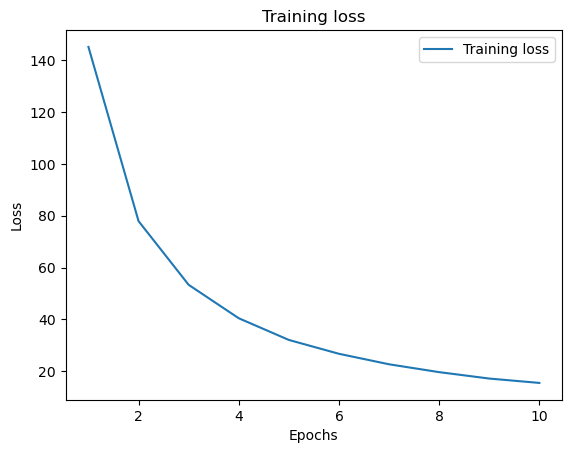

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, '-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


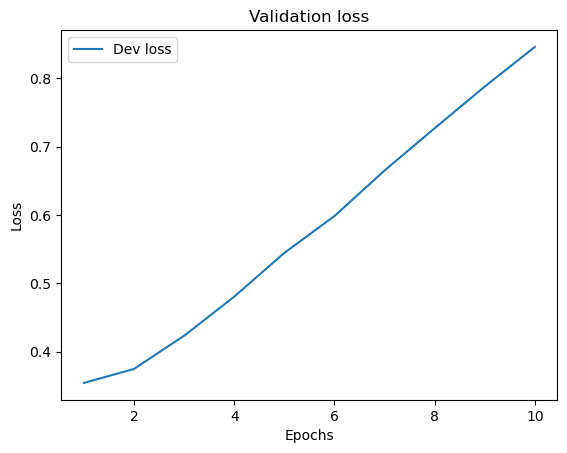

In [28]:
epochs = range(1, len(dev_losses) + 1)
plt.plot(epochs, dev_losses, '-', label='Dev loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

可以看到，训练集的损失在不断下降，但是验证集的损失在一定程度上上升，这是过拟合的表现。实际上只需要训练1轮就够了。或者通过  `nn.Dropout()`来缓解过拟合，但是这里不做过多讨论。

## 保存模型

In [29]:
torch.save(model.state_dict(), 'my_model.pth')

## 加载模型

注意到加载模型时要先实例化一个网络，然后再调用`load_state_dict()`方法加载参数。
在实际使用时需要，测试的代码有时候是和训练的代码分离的，这时候就需要把模型结构单独定义在一个文件里，然后在训练和测试的代码中都导入这个文件，这样就可以保证模型结构的一致性。

In [30]:
# 加载模型
model = TextClassifier(train_set.tfidf_dim, 128, 2)
model.load_state_dict(torch.load('my_model.pth'))

<All keys matched successfully>

## 在测试集上测试

注意此时是用的最后一次训练后的模型，并不是在验证集上表现最好的模型。如果希望能取出验证集上表现最好的模型，请了解早停法(early stopping)

In [32]:
# 测试模型
_ = test_fn(model, test_loader, loss_function)

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.898308 

